In [76]:
import warnings
warnings.filterwarnings('ignore')

## Data loading and inspection


In [77]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, TreeSearch, BayesianEstimator, BDeu


df = pd.read_csv("CVD_cleaned.csv")
print(f'dfset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

dfset contains 308854 rows and 19 columns


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [78]:
# Removes 'General_Health' and 'Checkup'
df.drop(columns=['General_Health', 'Checkup'], inplace=True)

# --- Create a new column 'Cancer' based on 'Skin_Cancer' and 'Other_Cancer'
df['Cancer'] = df.apply(lambda row: 'Yes' if row['Skin_Cancer'] == 'Yes' or row['Other_Cancer'] == 'Yes' else 'No', axis=1)

# Removes 'Skin_Cancer' and 'Other_Cancer' columns
df.drop(columns=['Skin_Cancer', 'Other_Cancer'], inplace=True)

print(len(df.columns))
df.columns

16


Index(['Exercise', 'Heart_Disease', 'Depression', 'Diabetes', 'Arthritis',
       'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI',
       'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'Cancer'],
      dtype='object')

In [79]:
for col in df.columns:
    uniques = np.sort(df[col].unique())
    print(f"{col}: lowest = {uniques[0]}, largest = {uniques[-1]}")

Exercise: lowest = No, largest = Yes
Heart_Disease: lowest = No, largest = Yes
Depression: lowest = No, largest = Yes
Diabetes: lowest = No, largest = Yes, but female told only during pregnancy
Arthritis: lowest = No, largest = Yes
Sex: lowest = Female, largest = Male
Age_Category: lowest = 18-24, largest = 80+
Height_(cm): lowest = 91.0, largest = 241.0
Weight_(kg): lowest = 24.95, largest = 293.02
BMI: lowest = 12.02, largest = 99.33
Smoking_History: lowest = No, largest = Yes
Alcohol_Consumption: lowest = 0.0, largest = 30.0
Fruit_Consumption: lowest = 0.0, largest = 120.0
Green_Vegetables_Consumption: lowest = 0.0, largest = 128.0
FriedPotato_Consumption: lowest = 0.0, largest = 128.0
Cancer: lowest = No, largest = Yes


## Dataset Columns Descriptions

Dataset link: [Dataset](https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset)

- **Exercise**: Indicates whether the individual participates in physical activity (e.g. "Yes" or "No").

- **Heart_Disease**: Reports if the individual has been diagnosed with heart disease.

- **Depression**: Indicates whether the individual has been diagnosed with depression.

- **Diabetes**: Reports the diabetes status. It may include simple "Yes"/"No" values or more detailed categories.

- **Arthritis**: Indicates if the individual has arthritis.

- **Sex**: The gender of the individual (e.g. "Male" or "Female").

- **Age_Category**: Categorical representation of the age range of the individual (e.g. "70-74", "80+").

- **Height_(cm)**: The height of the individual measured in centimeters.

- **Weight_(kg)**: The weight of the individual measured in kilograms.

- **BMI**: Body Mass Index calculated from height and weight, providing an estimate of body fat.

- **Smoking_History**: Indicates whether the individual has a history of smoking.

- **Alcohol_Consumption**: A measure of the individual's alcohol intake (number of alcoholic drinks each month); it is later discretized into categories (e.g. "Low" or "High").

- **Fruit_Consumption**: A measure of the amount of fruit consumed (number of fruits each month), later categorized (e.g. "Low" or "High").

- **Green_Vegetables_Consumption**: Indicates the consumption level of green vegetables (number of meals per month), categorized for analysis.

- **FriedPotato_Consumption**: Reports the consumption level of fried potatoes (number of meals per month), discretized into categories.

- **Cancer**: A derived column that indicates the occurrence of any cancer; it is set to "Yes" if either skin cancer or another form of cancer was reported, and "No" otherwise.


## Discretization of continuous variables


The cut-off numbers between the categories were chosen based on research carried out on the recommendations of international health bodies.

In [80]:
from sklearn.preprocessing import KBinsDiscretizer

# Columns to discretize using KBinsDiscretizer
to_discretize = ['Height_(cm)', 'Weight_(kg)', 'BMI']

# Initialize and apply the discretizer
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df_disc = df.copy()
df_disc[to_discretize] = discretizer.fit_transform(df[to_discretize])

# Define discretization rules for other columns
discretization_rules = {
    'BMI': {'bins': [-float('inf'), 18.5, 24.9, 29.9, float('inf')], 'labels': ['Underweight', 'Normal weight', 'Overweight', 'Obese']},
    'Alcohol_Consumption': {'bins': [-float('inf'), 10.0, float('inf')], 'labels': ['Low', 'High']},
    'Fruit_Consumption': {'bins': [-float('inf'), 50.0, float('inf')], 'labels': ['Low', 'High']},
    'Green_Vegetables_Consumption': {'bins': [-float('inf'), 30.0, float('inf')], 'labels': ['Low', 'High']},
    'FriedPotato_Consumption': {'bins': [-float('inf'), 10.0, float('inf')], 'labels': ['Low', 'High']}
}

# Apply discretization rules
for col, rule in discretization_rules.items():
    df_disc[col] = pd.cut(df[col], bins=rule['bins'], labels=rule['labels'])

# Show the distribution of the discretized columns
discretized_columns = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

for col in discretized_columns:
    print(f"Distribution of column '{col}':")
    print(df_disc[col].value_counts())
    print("\n")


Distribution of column 'Height_(cm)':
Height_(cm)
3.0    96973
1.0    76605
2.0    70514
0.0    64762
Name: count, dtype: int64


Distribution of column 'Weight_(kg)':
Weight_(kg)
1.0    83550
3.0    80225
2.0    76182
0.0    68897
Name: count, dtype: int64


Distribution of column 'BMI':
BMI
Overweight       109866
Obese            106738
Normal weight     87706
Underweight        4544
Name: count, dtype: int64


Distribution of column 'Alcohol_Consumption':
Alcohol_Consumption
Low     257101
High     51753
Name: count, dtype: int64


Distribution of column 'Fruit_Consumption':
Fruit_Consumption
Low     240512
High     68342
Name: count, dtype: int64


Distribution of column 'Green_Vegetables_Consumption':
Green_Vegetables_Consumption
Low     295832
High     13022
Name: count, dtype: int64


Distribution of column 'FriedPotato_Consumption':
FriedPotato_Consumption
Low     254460
High     54394
Name: count, dtype: int64




## Exploration of the correlation heatmap

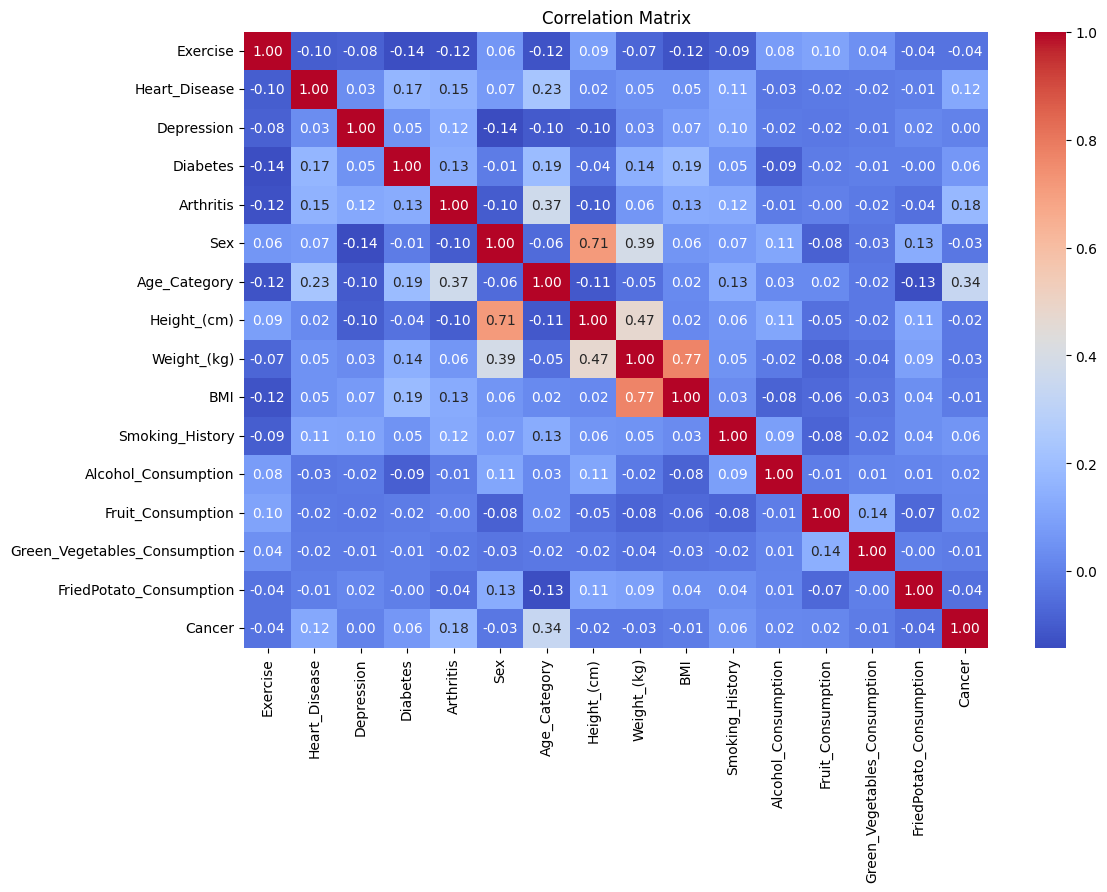

In [81]:
# Create a temporary DataFrame to avoid modifying the original
df_temp = df_disc.copy()

# --- Convert categorical variables to numerical codes
# This is necessary for correlation calculation
for col in df_temp.select_dtypes(include=['category', 'object']).columns:
    df_temp[col] = df_temp[col].astype('category').cat.codes

# Calculate and show the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Definition of a custom network structure

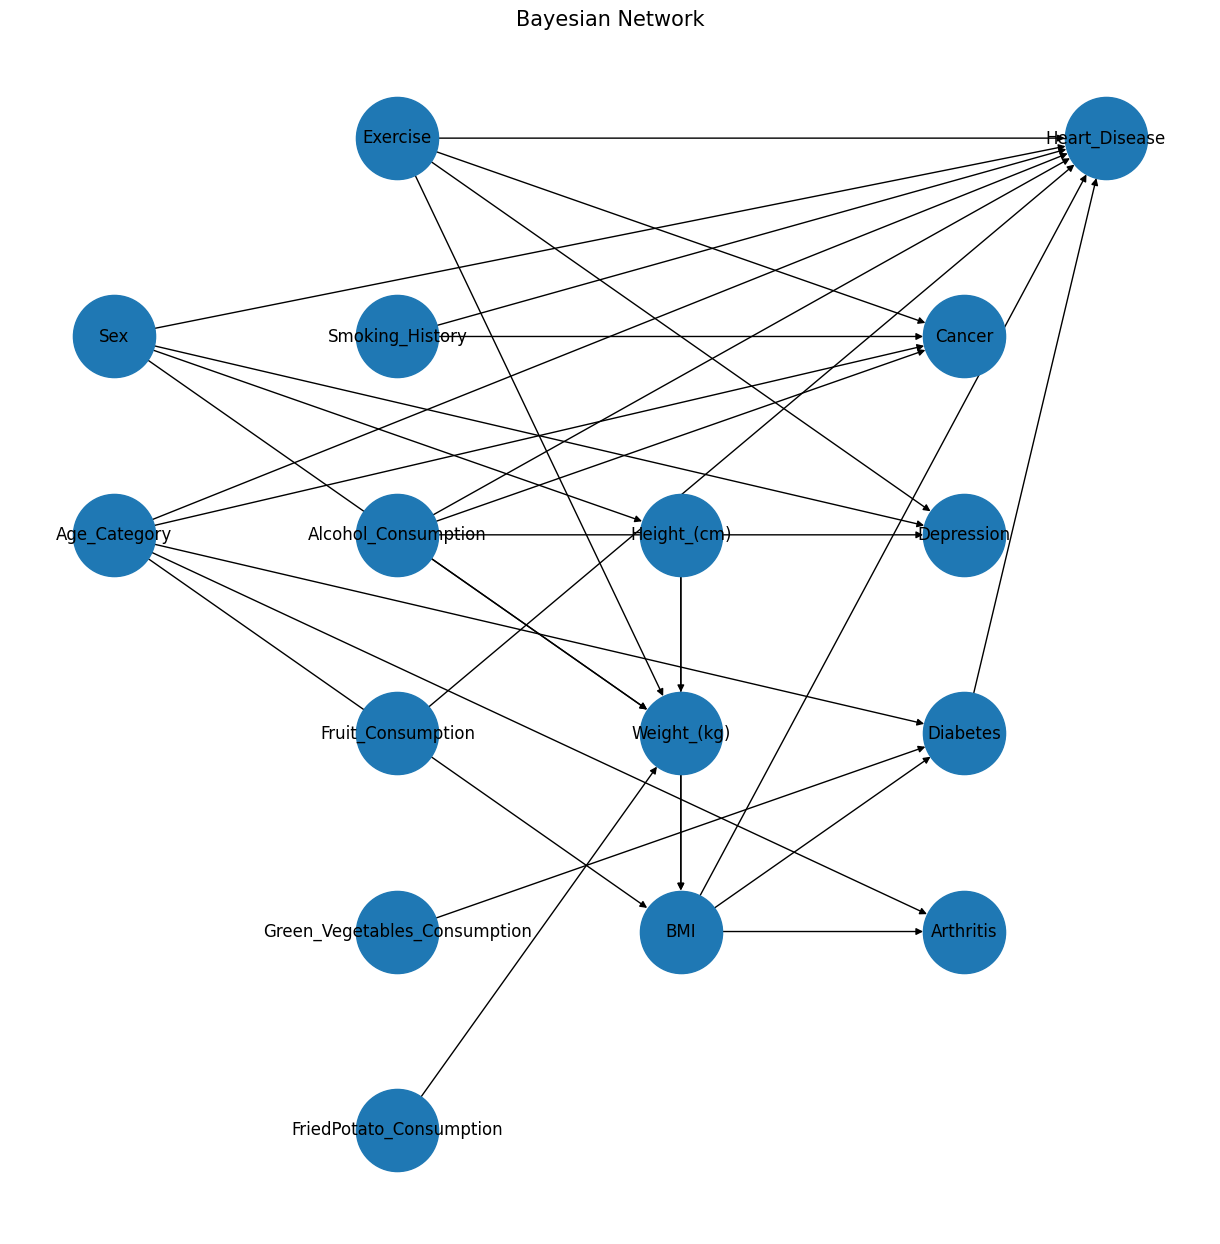

In [82]:
custom_model = DiscreteBayesianNetwork([
    ('Height_(cm)', 'Weight_(kg)'),  
    ('Height_(cm)', 'BMI'),  
    ('Weight_(kg)', 'BMI'),

    ('Sex', 'Heart_Disease'),  # Sex influences biological risk for heart disease
    ('Sex', 'Depression'),  # Sex differences in depression prevalence (e.g. women have higher rates)
    ('Sex', 'Weight_(kg)'),  
    ('Sex', 'Height_(cm)'),  

    ('Age_Category', 'Heart_Disease'),  # Heart disease risk increases with age
    ('Age_Category', 'Diabetes'),  # Age is a known risk factor for diabetes
    ('Age_Category', 'Arthritis'),  # Arthritis prevalence increases with age
    ('Age_Category', 'BMI'),  # BMI may increase or fluctuate with age due to metabolic changes
    ('Age_Category', 'Cancer'),  # Many cancers are more prevalent with age

    ('Smoking_History', 'Heart_Disease'),  
    ('Smoking_History', 'Cancer'),  

    ('Alcohol_Consumption', 'Heart_Disease'),  # Excessive alcohol can raise blood pressure and harm the heart
    ('Alcohol_Consumption', 'Cancer'),  # Alcohol consumption increases cancer risk (e.g. liver cancer)
    ('Alcohol_Consumption', 'Depression'),  # Alcohol use is associated with higher depression risk
    ('Alcohol_Consumption', 'Weight_(kg)'),  # Alcohol adds extra calories, potentially increasing weight

    ('Fruit_Consumption', 'Heart_Disease'),  # Diets rich in fruit are linked to lower heart disease risk

    ('Green_Vegetables_Consumption', 'Diabetes'),  # Vegetables can improve insulin sensitivity and reduce diabetes risk

    ('FriedPotato_Consumption', 'Weight_(kg)'),  

    ('Exercise', 'Heart_Disease'),  
    ('Exercise', 'Depression'),  # Exercise is known to improve mental health and reduce depression
    ('Exercise', 'Weight_(kg)'),  
    ('Exercise', 'Cancer'),  # Physical activity lowers risk of several cancers

    ('BMI', 'Heart_Disease'),  
    ('BMI', 'Diabetes'),  
    ('BMI', 'Arthritis'),  # Excess body weight adds stress on joints, increasing arthritis risk

    ('Diabetes', 'Heart_Disease'),  # Diabetes significantly increases cardiovascular disease risk
])




pos = {
    # Column 1: Demographics
    'Sex': (0, 3),
    'Age_Category': (0, 2),

    # Column 2: Lifestyle
    'Exercise': (2, 4),
    'Smoking_History': (2, 3),
    'Alcohol_Consumption': (2, 2),
    'Fruit_Consumption': (2, 1),
    'Green_Vegetables_Consumption': (2, 0),
    'FriedPotato_Consumption': (2, -1),

    # Column 3: Health Metrics
    'Height_(cm)': (4, 2),
    'Weight_(kg)': (4, 1),
    'BMI': (4, 0),

    # Column 4: Health Conditions
    'Heart_Disease': (7, 4),
    'Cancer': (6, 3),
    'Depression': (6, 2),
    'Diabetes': (6, 1),
    'Arthritis': (6, 0),
}

# Create a directed graph from the Bayesian model
plt.figure(figsize=(12, 12))
G = nx.DiGraph(custom_model.edges())
nx.draw(G, pos, with_labels=True, node_size=3500)

plt.title("Bayesian Network", fontsize=15)
plt.axis("off")
plt.show()


## Learn a Tree‐structured network

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}
Building tree: 100%|██████████| 120/120.0 [00:01<00:00, 76.47it/s]


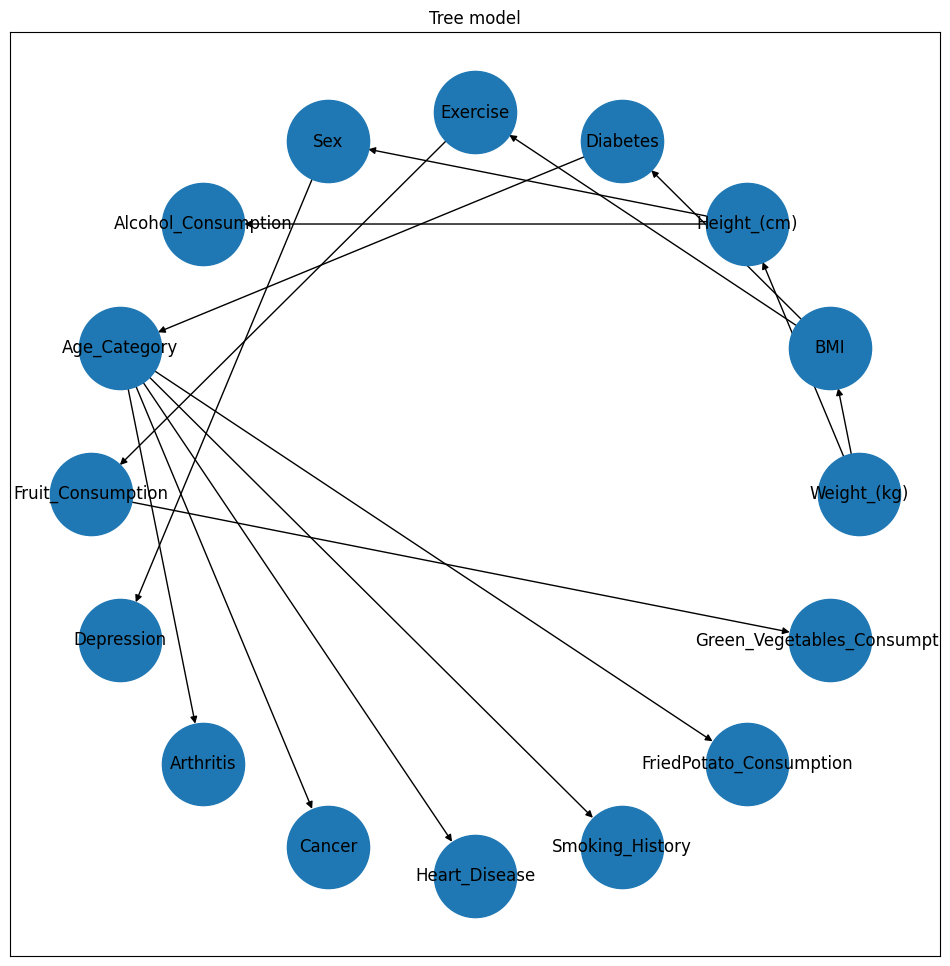

In [83]:
# Tree Search Model

ts = TreeSearch(data=df_disc)
# ts = TreeSearch(data=df_disc)
tree_model = ts.estimate()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3500)
ax.set_title('Tree model')
tree_model = DiscreteBayesianNetwork(tree_model.edges())

### Learn a fully general network via hill‐climbing


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'E

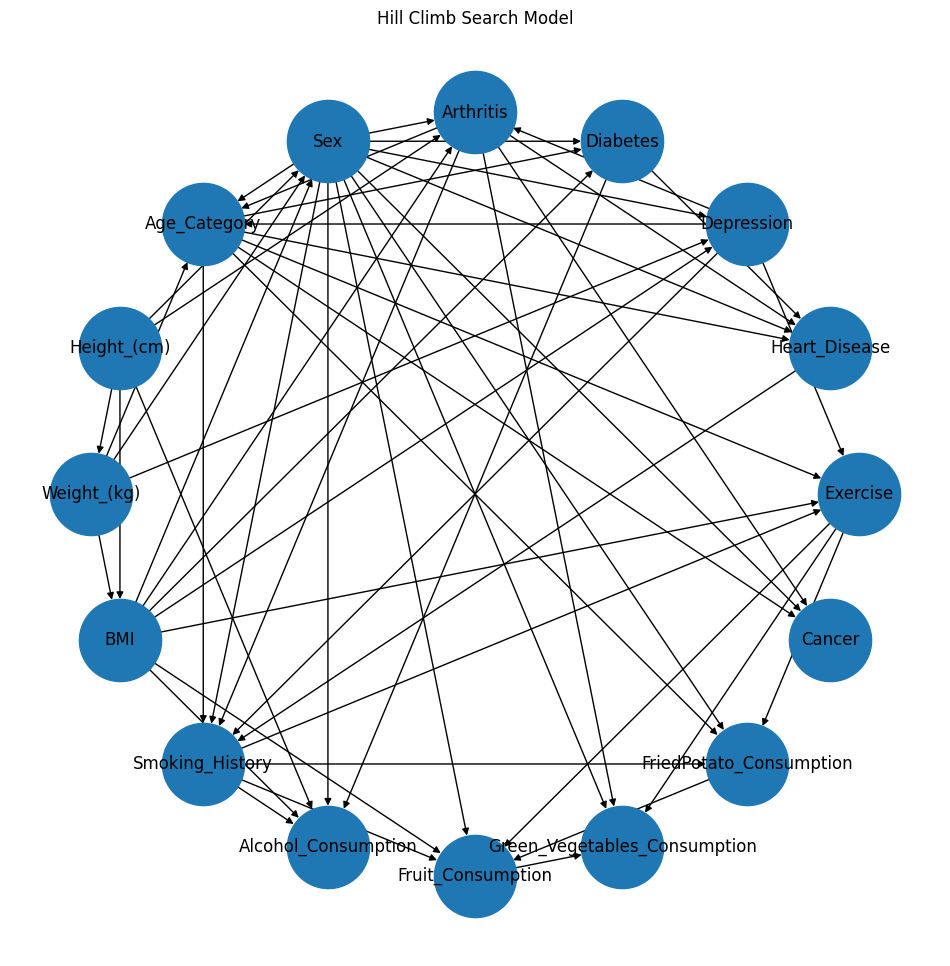

In [84]:
# Hill Climb Search Model
scorer = BDeu(data=df_disc)

hc = HillClimbSearch(data=df_disc)

hc_model = hc.estimate(scoring_method=scorer, show_progress=False)

plt.figure(figsize=(12, 12))
pos_hc = nx.drawing.layout.circular_layout(hc_model)
nx.draw_networkx(hc_model, pos=pos_hc, node_size=3500, with_labels=True, arrows=True)
plt.title('Hill Climb Search Model')
plt.axis('off')
plt.show()

hc_model_bayes = DiscreteBayesianNetwork(hc_model.edges())

In [85]:
# --- 1. GES (Greedy Equivalence Search) -------------------------------
from pgmpy.estimators import GES
from pgmpy.estimators import BIC
import networkx as nx
import matplotlib.pyplot as plt

# Build & learn structure
# Ensure the data is valid and properly formatted
ges_estimator = GES(df_disc)

# Use the BIC scoring method to estimate the model
try:
	ges_model = ges_estimator.estimate(scoring_method=BIC(df_disc))
except StopIteration:
	raise ValueError("The GES estimator encountered an issue. Please check the input data for validity.")

# Learn CPD with (light) Dirichlet smoothing
ges_model.fit(df_disc, estimator=BayesianEstimator)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'E

In [86]:
"""
# --- 2. MMHC (Max–Min Hill-Climbing) ---------------------------------
from pgmpy.estimators import MmhcEstimator, BIC
import networkx as nx
import matplotlib.pyplot as plt

# Build structure (constraint phase + score phase)
mmhc_estimator = MmhcEstimator(df_disc)
mmhc_model = mmhc_estimator.estimate(scoring_method=BIC(df_disc))

# Learn CPD with the same smoothing
mmhc_model.fit(df_disc, estimator=BayesianEstimator, pseudo_counts=0.5)
    
"""


'\n# --- 2. MMHC (Max–Min Hill-Climbing) ---------------------------------\nfrom pgmpy.estimators import MmhcEstimator, BIC\nimport networkx as nx\nimport matplotlib.pyplot as plt\n\n# Build structure (constraint phase + score phase)\nmmhc_estimator = MmhcEstimator(df_disc)\nmmhc_model = mmhc_estimator.estimate(scoring_method=BIC(df_disc))\n\n# Learn CPD with the same smoothing\nmmhc_model.fit(df_disc, estimator=BayesianEstimator, pseudo_counts=0.5)\n    \n'

### Parameter learning (CPDs)


In [87]:
# Compute CPDs for all models

models = [('custom', custom_model), ('tree', tree_model), ('hc', hc_model_bayes)]
for name, model in models:
    print(f'Computing CPDs for {name} model')
    model.fit(df_disc, estimator=BayesianEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}


Computing CPDs for custom model


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}


Computing CPDs for tree model
Computing CPDs for hc model


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}


# Questions

In [88]:
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt

# Create inference objects for the models
infer_custom = VariableElimination(custom_model)
infer_tree = VariableElimination(tree_model)
infer_hc = VariableElimination(hc_model_bayes)
#infer_ges = VariableElimination(ges_model)
# infer_mmhc = VariableElimination(mmhc_model)

import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.inference import VariableElimination


def query_func(target: str, evid_a: dict, evid_b: dict):
    """
    Compare two evidence scenarios (Scenario A vs Scenario B) across the
    three Bayesian networks that have already been trained in the
    notebook—namely ``custom_model``, ``tree_model``, and ``hc_model``—
    and display a paired bar chart that exactly replicates the visual
    style used in the original notebook.

    Parameters
    ----------
    target : str
        The name of the target variable (for example ``"Cancer"``). The
        function assumes that the *positive* state of this binary
        variable (e.g. *Yes*) is located at index 1 in the CPD array.
    evid_a : dict
        Dictionary of evidences for Scenario A in the form
        ``{"Variable": "State", ...}``.
    evid_b : dict
        Dictionary of evidences for Scenario B in the same format.

    Notes
    -----
    * The list of models and their labels is hard-coded in order to keep
      the function signature minimal and to guarantee consistency with
      the rest of the notebook.
    * The chart reproduces the visual grammar already established:
        - a white-grid background (Seaborn)
        - paired bars per model with a fixed width (0.35)
        - the bars for Scenario B are hatched (“//”) to enhance
          contrast.
    * If the *positive* state of *target* is **not** located at index 1,
      modify the line that extracts ``q.values[1]`` accordingly.
    """

    # Fixed list of Bayesian models and their display labels
    inferences = [infer_custom, infer_tree, infer_hc] # infer_ges infer_mmhc
    labels = ["Domain-driven", "Chow-Liu", "Hill-Climb"] # GES MMHC

    # Print the evidence scenarios
    print("Scenario A Evidence:", evid_a)
    print("Scenario B Evidence:", evid_b)

    # Compute P(target = Yes) for both scenarios in each model
    p_a, p_b = [], []
    for infer in inferences:
        q_a = infer.query([target], evidence=evid_a)
        q_b = infer.query([target], evidence=evid_b)

        # index 1 corresponds to the “Yes” state in a binary variable
        p_a.append(float(q_a.values[1]))
        p_b.append(float(q_b.values[1]))

    # Plotting – faithful to the style used elsewhere in the notebook
    sns.set_style("whitegrid")
    width = 0.35                      # width of each bar
    x = range(3)                      # x positions: 0, 1, 2

    plt.figure(figsize=(8, 5))

    # Left bars – Scenario A
    plt.bar(
        [i - width / 2 for i in x],
        p_a,
        width=width,
        label="Scenario A",
        edgecolor="black"
    )

    # Right bars – Scenario B (hatched for visual distinction)
    plt.bar(
        [i + width / 2 for i in x],
        p_b,
        width=width,
        label="Scenario B",
        edgecolor="black",
        hatch="//"
    )

    # Cosmetic details matching the notebook's look & feel
    plt.xticks(x, labels, fontsize=12)
    plt.ylabel(f"P({target} = Yes)", fontsize=12)
    plt.title(f"{target}: Scenario A vs B", fontsize=14, pad=10)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Example query:

Scenario A Evidence: {'Smoking_History': 'No', 'Exercise': 'Yes'}
Scenario B Evidence: {'Smoking_History': 'Yes', 'Exercise': 'No'}


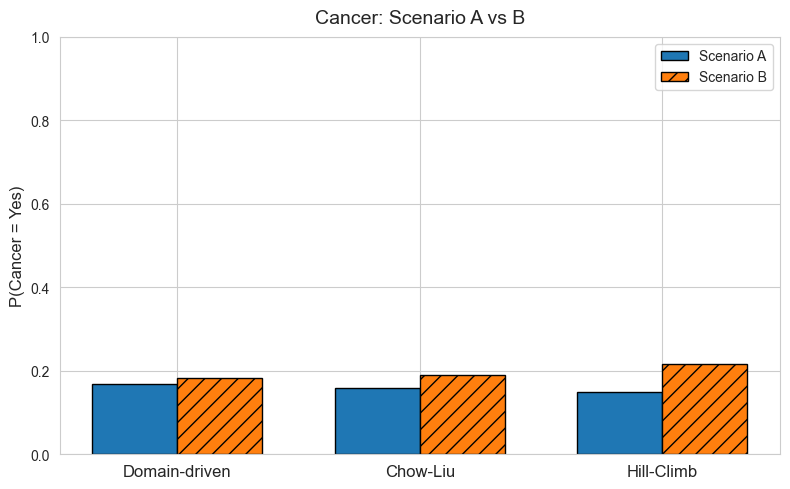

In [89]:
scenario_A = {'Smoking_History': 'No', 'Exercise': 'Yes'}
scenario_B = {'Smoking_History': 'Yes', 'Exercise': 'No'}

# grafico per il cancro
query_func("Cancer", scenario_A, scenario_B)

## Query 1:


Scenario A Evidence: {'FriedPotato_Consumption': 'High'}
Scenario B Evidence: {'FriedPotato_Consumption': 'Low'}


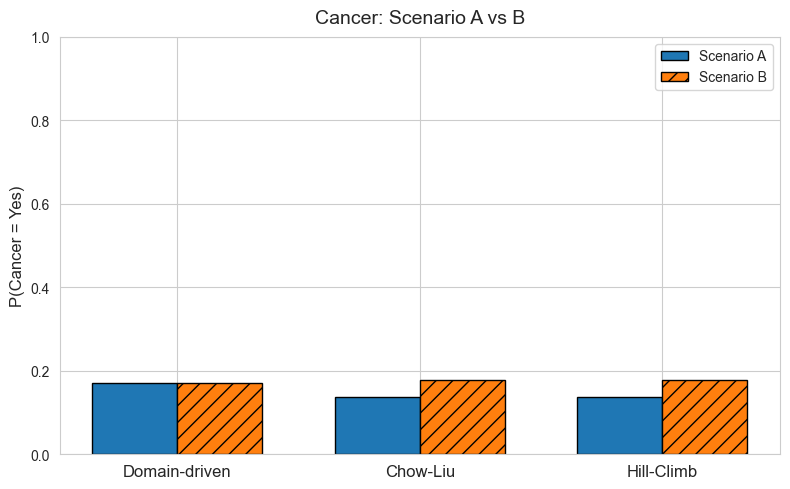

In [ ]:
scenario_A = {'FriedPotato_Consumption': 'High'}
scenario_B = {'FriedPotato_Consumption': 'Low'}

query_func("Cancer", scenario_A, scenario_B)

## Query 2:

Scenario A Evidence: {'BMI': 'Normal weight', 'Exercise': 'No'}
Scenario B Evidence: {'FriedPotato_Consumption': 'Low'}


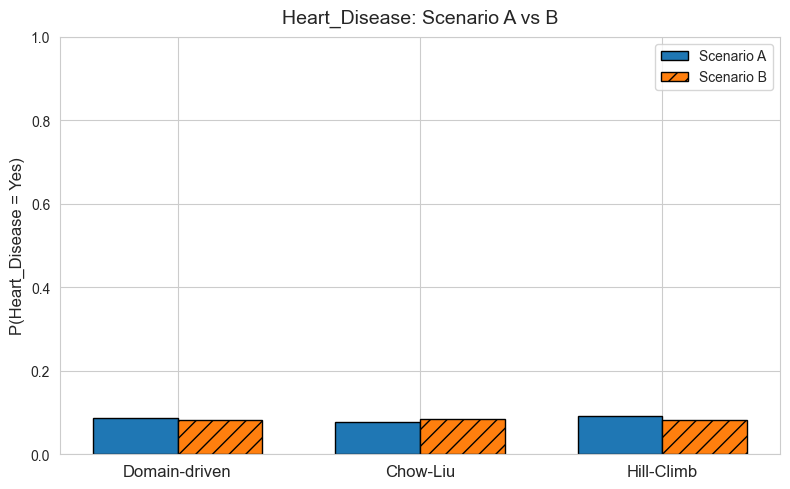

In [94]:
scenario_A = {'BMI': 'Obese', 'Exercise': 'Yes'}
scenario_A = {'BMI': 'Normal weight', 'Exercise': 'No'}

query_func("Heart_Disease", scenario_A, scenario_B)

## Query 3:

Scenario A Evidence: {'Alcohol_Consumption': 'High'}
Scenario B Evidence: {'Alcohol_Consumption': 'Low'}


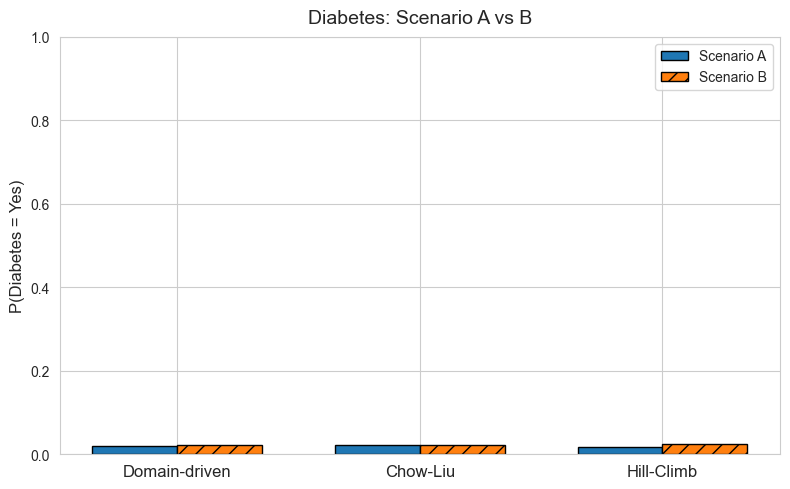

In [98]:
scenario_A = {'Alcohol_Consumption': 'High'}
scenario_B = {'Alcohol_Consumption': 'Low'}

query_func("Diabetes", scenario_A, scenario_B)

## Query 4

Scenario A Evidence: {'Alcohol_Consumption': 'High', 'Smoking_History': 'Yes'}
Scenario B Evidence: {'Alcohol_Consumption': 'Low', 'Smoking_History': 'No'}


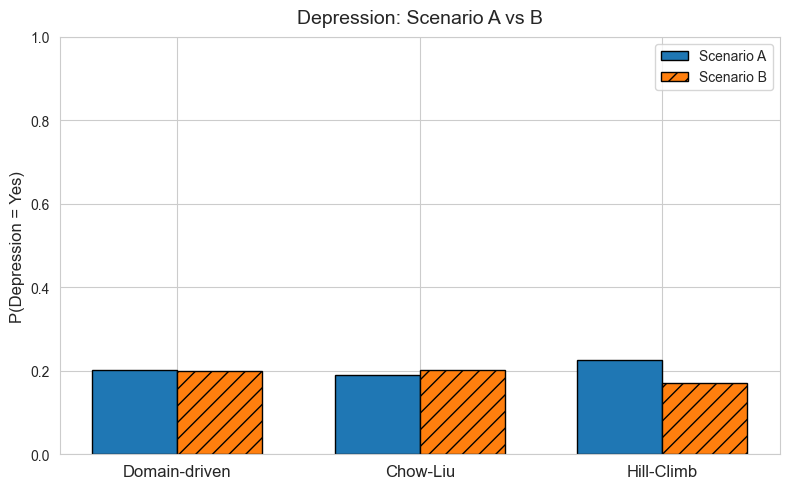

In [100]:
scenario_A = {'Alcohol_Consumption': 'High', 'Smoking_History': 'Yes'}
scenario_B = {'Alcohol_Consumption': 'Low', 'Smoking_History': 'No'}

query_func("Depression", scenario_A, scenario_B)

## Query 1:
"What's the probability of developing a cardiac disease given that the patient is non smoker and athletic?"

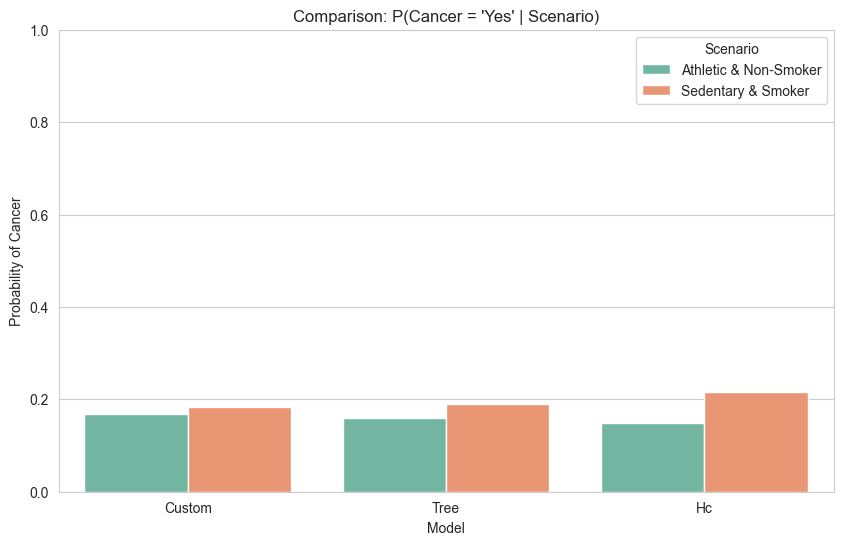

In [91]:
# Definition of scenarios to compare
scenarios = {
    "Athletic & Non-Smoker": {'Smoking_History': 'No', 'Exercise': 'Yes'},
    "Sedentary & Smoker": {'Smoking_History': 'Yes', 'Exercise': 'No'}
}

# List of models
models = {
    'Custom': infer_custom,
    'Tree': infer_tree,
    'Hc': infer_hc
}

# Perform queries and collect results
data = []
for scenario_label, evidence in scenarios.items():
    for model_label, model in models.items():
        result = model.query(variables=['Cancer'], evidence=evidence)
        try:
            states = result.state_names['Cancer']
        except (AttributeError, KeyError):
            states = ['No', 'Yes']
        for state, prob in zip(states, result.values):
            data.append({
                'Scenario': scenario_label,
                'Model': model_label,
                'Cancer': state,
                'Probability': prob
            })

# Create a DataFrame for visualization
df_plot = pd.DataFrame(data)

# Filter only the probability of Cancer = 'Yes'
df_yes = df_plot[df_plot['Cancer'] == 'Yes']

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_yes, x='Model', y='Probability', hue='Scenario', ci=None, palette="Set2", dodge=True)
plt.title("Comparison: P(Cancer = 'Yes' | Scenario)")
plt.ylim(0, 1)
plt.ylabel("Probability of Cancer")
plt.show()

- All three methods agree that being sedentary and a smoker raises the probability of cancer compared to being athletic and a non-smoker.

- The Custom and Tree engines give fairly similar estimates (~0.17 vs. ~0.18–0.19), whereas the HC sampler shows a slightly larger gap, pushing the risk under the unhealthy scenario up to 22%.

- This suggests the HC sampling may be amplifying the tail of the distribution, leading to more extreme event probabilities in the “worse” scenario.

## Query 2:
"What is the combined effect of factors such as alcohol consumption, diet (fruit, vegetables, and fried potatoes) and physical activity on the probability of developing hearth deseases?"

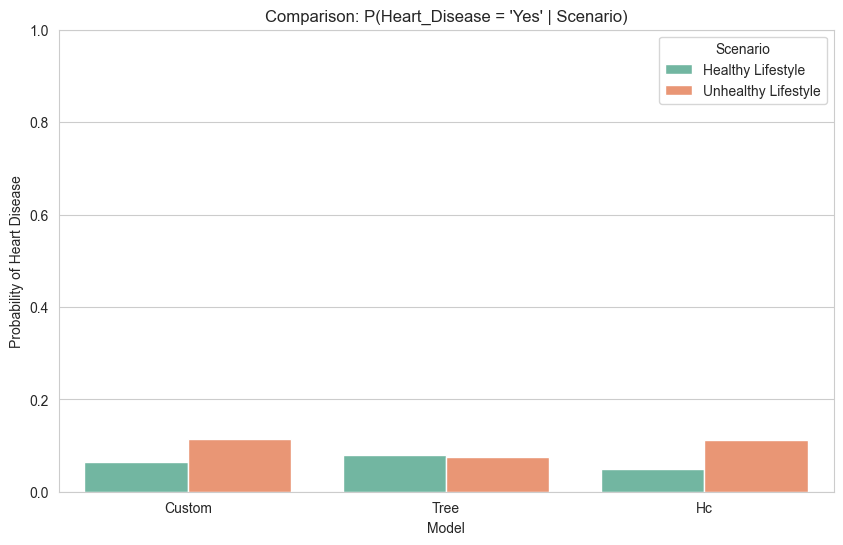

In [92]:
def new_func():
    # Defines the scenarios to compare
    scenarios_heart_disease = {
        "Healthy Lifestyle": {
            'Exercise': 'Yes',
            'Alcohol_Consumption': 'Low',
            'Fruit_Consumption': 'High',
            'Green_Vegetables_Consumption': 'High',
            'FriedPotato_Consumption': 'Low',
            'Smoking_History': 'No'
        },
        "Unhealthy Lifestyle": {
            'Exercise': 'No',
            'Alcohol_Consumption': 'High',
            'Fruit_Consumption': 'Low',
            'Green_Vegetables_Consumption': 'Low',
            'FriedPotato_Consumption': 'High',
            'Smoking_History': 'Yes'
        }
    }

    # Executes the queries and collects the results
    data_heart_disease = []
    for scenario_label, evidence in scenarios_heart_disease.items():
        for model_label, model in models.items():
            result = model.query(variables=['Heart_Disease'], evidence=evidence)
            try:
                states = result.state_names['Heart_Disease']
            except (AttributeError, KeyError):
                states = ['No', 'Yes']
            for state, prob in zip(states, result.values):
                data_heart_disease.append({
                    'Scenario': scenario_label,
                    'Model': model_label,
                    'Heart_Disease': state,
                    'Probability': prob
                })

    # Creates a DataFrame for visualization
    df_heart_disease_plot = pd.DataFrame(data_heart_disease)

    # Filters only the probability of Heart_Disease = 'Yes'
    df_heart_disease_yes = df_heart_disease_plot[df_heart_disease_plot['Heart_Disease'] == 'Yes']

    # Plots the grouped bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_heart_disease_yes, x='Model', y='Probability', hue='Scenario', ci=None, palette="Set2", dodge=True)
    plt.title("Comparison: P(Heart_Disease = 'Yes' | Scenario)")
    plt.ylim(0, 1)
    plt.ylabel("Probability of Heart Disease")
    plt.show()

new_func()

The Custom and HC engines predict a small increase in heart disease risk for an unhealthy lifestyle, on the order of +1 percentage point.

Interestingly, the Tree-based method actually flips this intuition, showing a slightly lower probability (0.06) under the unhealthy scenario. This may point to:

- Over-pruning or smoothing in the decision tree

- Insufficient data to capture the negative effect of an unhealthy lifestyle

Overall, the effect size is small in all models (< 3 pp), so the network’s structural relationships around lifestyle and heart disease seem weak.

Americans eat on average about 355 mL of vegetables daily, according to the USDA. By contrast, national nutrition guidelines recommend adults consume between roughly 475 mL and 710 mL of vegetables each day. More than half of that intake comes from potatoes and tomatoes, whereas only about 10 percent comes from dark green and orange vegetables such as spinach, carrots, and sweet potatoes.

## Query 3
""

## Query 4
"Does a person's sex influence the risk of developing diabetes?"

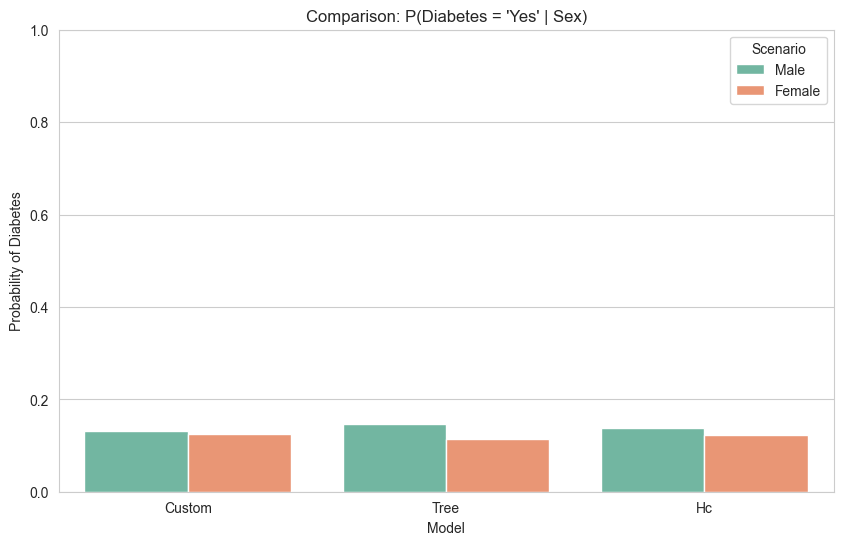

In [93]:
# Define scenarios for different sexes
scenarios_sex = {
    "Male": {'Sex': 'Male'},
    "Female": {'Sex': 'Female'}
}

# Perform queries for each model and collect results
data_sex_diabetes = []
for scenario_label, evidence in scenarios_sex.items():
    for model_label, model in models.items():
        result = model.query(variables=['Diabetes'], evidence=evidence)
        try:
            states = result.state_names['Diabetes']
        except (AttributeError, KeyError):
            states = ['No', 'Yes']
        for state, prob in zip(states, result.values):
            data_sex_diabetes.append({
                'Scenario': scenario_label,
                'Model': model_label,
                'Diabetes': state,
                'Probability': prob
            })

# Create a DataFrame for visualization
df_sex_diabetes_plot = pd.DataFrame(data_sex_diabetes)

# Filter only the probability of Diabetes = 'Yes'
df_sex_diabetes_yes = df_sex_diabetes_plot[df_sex_diabetes_plot['Diabetes'] == 'Yes']

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sex_diabetes_yes, x='Model', y='Probability', hue='Scenario', ci=None, palette="Set2", dodge=True)
plt.title("Comparison: P(Diabetes = 'Yes' | Sex)")
plt.ylim(0, 1)
plt.ylabel("Probability of Diabetes")
plt.show()

All three engines consistently predict a slightly higher diabetes risk for males versus females (by 1–4 pp).

This alignment suggests the network has a clear edge or factor that ties sex → diabetes, and it survives regardless of the inference method.

The Tree model shows the largest gap (0.15 vs. 0.11), again hinting that its discretization amplifies some dependencies more aggressively.